# ----- 0. Import Libraries -----

In [1]:
# Standard library imports
import datetime
import os
import random

# Third-party library imports
import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import seaborn as sns
from zipfile import ZipFile

# TensorFlow/Keras imports
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Libraries imported successfully.")

Libraries imported successfully.


# ----- 1. Set Up Environment & Reproducibility -----

In [2]:
print("\n----- 1. Set Up Environment & Reproducibility -----")
print("Setting up environment and ensuring reproducibility.")

# Set random seeds for reproducibility across runs
seed_value = 42
random.seed(seed_value)         # Python's built-in random module
np.random.seed(seed_value)      # NumPy random seed
tf.random.set_seed(seed_value)  # TensorFlow random seed (includes Keras backend)

# Create project directories if they don't exist
model_directory = "tme_models"
data_directory = "tme_data"
figure_directory = "tme_figures"

for directory in [model_directory, data_directory, figure_directory]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

print("Environment setup complete.")


----- 1. Set Up Environment & Reproducibility -----
Setting up environment and ensuring reproducibility.
Directory already exists: tme_models
Directory already exists: tme_data
Directory already exists: tme_figures
Environment setup complete.


# ----- 2. Data Acquisition and Initial Exploration -----


----- 2. Data Acquisition and Initial Exploration -----
Kaggle API authenticated.
Unzipped data not found. Checking for zip file or initiating download...
Data downloaded successfully.
Unzipping data...
Data unzipped successfully.
----------------------------------------------------------------------------------------------------
Data directory contents: ['train_labels.csv', 'histopathologic-cancer-detection.zip', '.DS_Store', 'test', 'train', 'sample_submission.csv']
Loading training labels from 'train_labels.csv' into a pandas DataFrame.
Training labels loaded successfully.
Labels converted to string type for ImageDataGenerator.
First few rows of the training labels DataFrame:
                                         id label
0  f38a6374c348f90b587e046aac6079959adf3835     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1
2  755db6279dae599ebb4d39a9123cce439965282d     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0
4  068aba587a4950175d04c680d38943fd488d6a9d     0
Shape of th

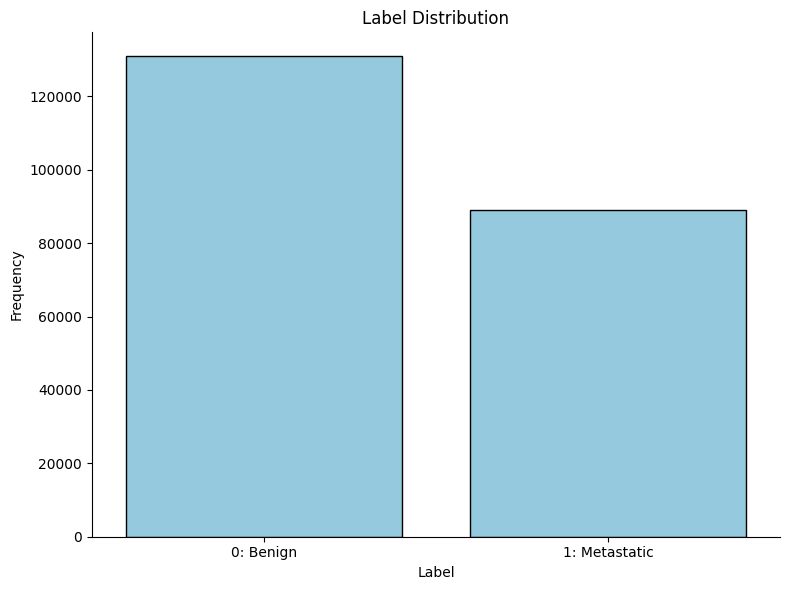

In [3]:
print("\n----- 2. Data Acquisition and Initial Exploration -----")
print("Downloading and unzipping data from Kaggle competition: 'Histopathologic Cancer Detection'.")

# Define the expected path for the downloaded zip file
zip_file_path = os.path.join(data_directory, 'histopathologic-cancer-detection.zip')

# Define the path for the main unzipped training image folder
# The Kaggle competition unzips into 'train' and 'test' subdirectories
unzipped_data_check_path = os.path.join(data_directory, 'train')    # Check for the 'train' subfolder as an indicator

try:
    kaggle.api.authenticate()   # Authenticate Kaggle API
    print("Kaggle API authenticated.")  

    # Check if unzipped data is already present
    if os.path.exists(unzipped_data_check_path) and os.path.isdir(unzipped_data_check_path):
        print(f"Unzipped data (e.g., '{os.path.basename(unzipped_data_check_path)}' folder) already exists. Skipping download and unzip steps.")
    else:
        # If unzipped data is NOT present, proceed with download/unzip
        print("Unzipped data not found. Checking for zip file or initiating download...")

        if os.path.exists(zip_file_path):
            print(f"Zip file already exists: {zip_file_path}.")
            print("Proceeding to unzip the existing file.")
        else:
            print("Downloading data from Kaggle competition: 'Histopathologic Cancer Detection'.")
            # Ensure you have accepted the competition terms on the Kaggle website
            kaggle.api.competition_download_files('histopathologic-cancer-detection', path=data_directory)
            print("Data downloaded successfully.")

        # Always attempt to unzip if the unzipped data isn't there
        # This covers cases where zip exists but unzipping failed previously.
        print("Unzipping data...")
        with ZipFile(zip_file_path, 'r') as zip_data:
            zip_data.extractall(data_directory)
        print("Data unzipped successfully.")

except Exception as e:
    print(f"Error during data acquisition (download/unzip/authentication): {e}")
    print("Please ensure you have installed the Kaggle API client (`pip install kaggle`),")
    print("placed your 'kaggle.json' file correctly, and accepted the competition rules on Kaggle.")

print("-" * 100)    # Full-width separator for readability

# List contents of the data directory to verify
print("Data directory contents:", os.listdir(data_directory))

# Load the data into a pandas DataFrame
print("Loading training labels from 'train_labels.csv' into a pandas DataFrame.")
train_labels_path = os.path.join(data_directory, 'train_labels.csv')
try:
    train_labels_df = pd.read_csv(train_labels_path)
    print("Training labels loaded successfully.")

    # Convert labels to string type for ImageDataGenerator
    train_labels_df['label'] = train_labels_df['label'].astype('str')
    print("Labels converted to string type for ImageDataGenerator.")
    
    # Display the first few rows of the DataFrame
    print("First few rows of the training labels DataFrame:")
    print(train_labels_df.head())
    
    # Check the shape of the DataFrame
    print("Shape of the training labels DataFrame:", train_labels_df.shape) 
    
    # Check the distribution of the label column
    label_distribution = train_labels_df['label'].value_counts()
    print("Label distribution:")
    print(label_distribution)
    
    # Plot the label distribution
    plt.figure(figsize=(8, 6))  
    ax = sns.barplot(x=label_distribution.index, y=label_distribution.values, color='skyblue', edgecolor='black')
    sns.despine()
    plt.title("Label Distribution")
    plt.xlabel("Label")
    plt.ylabel("Frequency")

    current_labels = ax.get_xticks()            # Get the current x-tick labels (which are 0 and 1)
    new_labels = ['0: Benign', '1: Metastatic'] # Ensure order matches x-axis (0 then 1)
    ax.set_xticks(current_labels)               # Set the x-ticks to the current positions
    ax.set_xticklabels(new_labels)              # Set the text for the x-ticks

    plt.tight_layout()
    plt.savefig(os.path.join(figure_directory, 'label_distribution.png'), dpi=300)
    print("Label distribution plot saved as 'label_distribution.png' in the figures directory.")
except FileNotFoundError:
    print(f"Error: The file '{train_labels_path}' does not exist. Please check the data directory.")  

# Construct image paths
print("Constructing image paths for training images.")
train_labels_df['image_path'] = train_labels_df['id'].apply(lambda x: os.path.join(data_directory, 'train', f"{x}.tif"))
print("Image paths constructed successfully.")

# Display the first few rows of the DataFrame with image paths
print("First few rows of the DataFrame with image paths:")
print(train_labels_df.head())

print("Shape of the training labels DataFrame:", train_labels_df.shape)

# ----- 3. Data Preprocessing -----


----- 3. Data Preprocessing -----
Splitting the dataset into training and validation sets.
Data split completed.
Training set size: 176020 images, 176020 labels
Validation set size: 44005 images, 44005 labels
Label distribution in training set:
label
0    0.594966
1    0.405034
Name: proportion, dtype: float64
Label distribution in validation set:
label
0    0.594978
1    0.405022
Name: proportion, dtype: float64
Generating data generators for training and validation sets.
Dimensions of the first training image: 96x96 pixels
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Data generators created successfully.
Training generator details:
Number of batches per epoch: 5500
Class indices: {'0': 0, '1': 1}
Image shape: (96, 96, 3)
Validation generator details:
Number of batches per epoch: 1375
Class indices: {'0': 0, '1': 1}
Image shape: (96, 96, 3)
Visualising some augmented images from the training generator.
Au

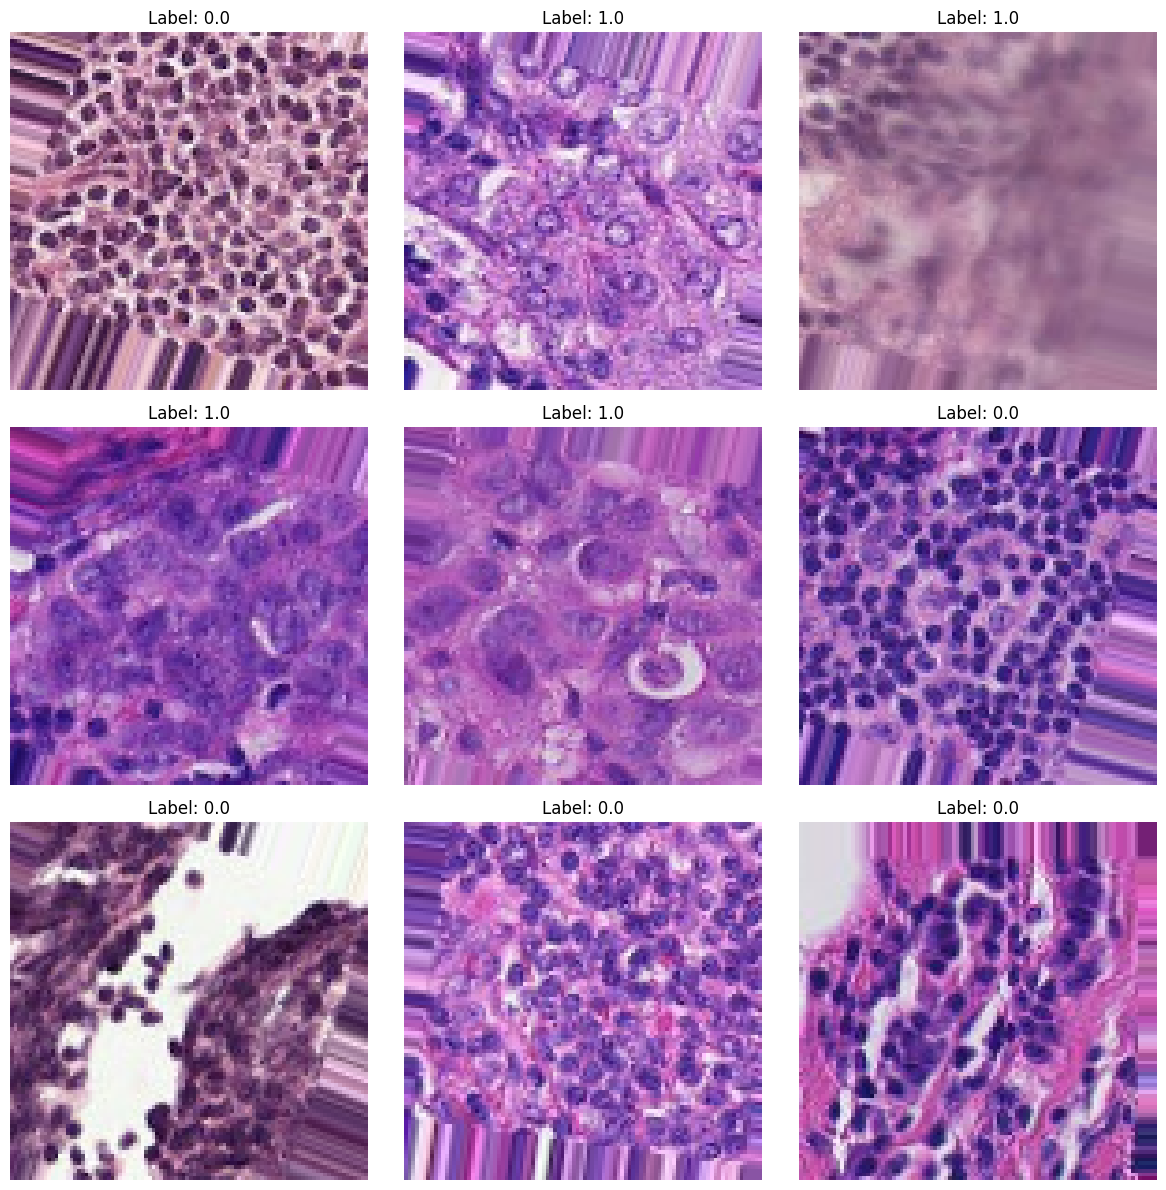

In [4]:
print("\n----- 3. Data Preprocessing -----")

print("Splitting the dataset into training and validation sets.")
# Define X (features) and y (labels)
X = train_labels_df['image_path']
y = train_labels_df['label']

# Split the data into training and validation sets
# Using 80% for training and 20% for validation
# stratify=y ensures that the proportion of labels is maintained in both splits
# random_state ensures reproducibility of the split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Data split completed.")

print(f"Training set size: {len(X_train)} images, {len(y_train)} labels")
print(f"Validation set size: {len(X_val)} images, {len(y_val)} labels")

# Verify the distribution in splits
print("Label distribution in training set:")
print(y_train.value_counts(normalize=True))

print("Label distribution in validation set:")
print(y_val.value_counts(normalize=True))

print("Generating data generators for training and validation sets.")

# Check image dimensions
tiff_image = Image.open(X_train.iloc[0])    # Open the first image in the training set
width, height = tiff_image.size             # Get the dimensions of the image
print(f"Dimensions of the first training image: {width}x{height} pixels")   # 96x96 pixels

# Create ImageDataGenerators for data augmentation and normalisation
# Using rescale to normalise pixel values to [0, 1]
# Data augmentation techniques are applied only to the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,                         # Normalise pixel values to [0, 1]
    rotation_range=20,                      # Randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.1,                  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,                 # Randomly shift images vertically (fraction of total height)
    shear_range=0.1,                        # Randomly shear images
    zoom_range=0.1,                         # Randomly zoom into images
    horizontal_flip=True,                   # Randomly flip images horizontally
    fill_mode='nearest',                    # Fill in new pixels with the nearest pixel value
)

val_datagen = ImageDataGenerator(
    rescale=1./255                          # Only rescale pixel values for validation set
)   

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train.to_frame().join(y_train.to_frame()),  # Combine features and labels into a DataFrame
    x_col="image_path",
    y_col="label",
    target_size=(96, 96),
    batch_size=32,
    class_mode="binary",
    shuffle=True,                                           # Shuffle the training data
    seed=seed_value                     
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val.to_frame().join(y_val.to_frame()),      # Combine features and labels into a DataFrame
    x_col="image_path",
    y_col="label",
    target_size=(96, 96),
    batch_size=32,
    class_mode="binary",
    shuffle=False,                                          # Do not shuffle the validation data
    seed=seed_value                     
)

print("Data generators created successfully.")

print("Training generator details:")
print(f"Number of batches per epoch: {train_generator.samples // train_generator.batch_size}")  
print(f"Class indices: {train_generator.class_indices}")                                        
print(f"Image shape: {train_generator.image_shape}")                                              

print("Validation generator details:")
print(f"Number of batches per epoch: {val_generator.samples // val_generator.batch_size}")      
print(f"Class indices: {val_generator.class_indices}")                                          
print(f"Image shape: {val_generator.image_shape}")                                              

# Iterate through the training generator to visualise some augmented images
print("Visualising some augmented images from the training generator.")
plt.figure(figsize=(12, 12))
for i in range(9):  # Display 9 images
    img, label = next(train_generator)  # Get the next batch of images and labels
    plt.subplot(3, 3, i + 1)            # Create a 3x3 grid of subplots
    plt.imshow(img[0])                  # Display the first image from 9 different batches; to display the first nine images from one batch change to img[i] and move next(train_generator) outside the loop
    plt.title(f"Label: {label[0]}")
    plt.axis('off')                     # Hide axes
plt.tight_layout()
plt.savefig(os.path.join(figure_directory, 'augmented_images.png'), dpi=300)
print("Augmented images visualised and saved as 'augmented_images.png' in the figures directory.")

# ----- 4. Model Building and Training -----

In [5]:
print("\n----- 4. Model Building and Training -----")

print("Building a Convolutional Neural Network (CNN) model for image classification.")

# Define the CNN model architecture
def build_model(hp):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(96, 96, 3),        # Input shape for the model
        include_top=False,              # Exclude the top layer (fully connected layers)
        weights='imagenet'              # Use pre-trained weights from ImageNet
    )
    base_model.trainable = False        # Freeze the base model layers

    x = base_model(base_model.input, training=False)   # Run through the frozen base model

    # Add a Global Average Pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Tune the number of units (i.e. neurons) in the dense classification head
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    x = tf.keras.layers.Dense(hp_units, activation='relu')(x)

    # Tune the dropout rate
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = tf.keras.layers.Dropout(hp_dropout_rate)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Tune the optimiser
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', 'AUC']
    )

    return model

# Create a Keras Tuner object to search for the best hyperparameters
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',          # Objective to optimise
    max_trials=10,                     # Number of different hyperparameter combinations to try
    executions_per_trial=1,            # Number of times to train each model
    directory=model_directory,         # Directory to save the models and logs
    project_name='tme_cnn_tuning'      # Project name for the tuner
)

print("\n--- Random Search Space Summary ---")
tuner.search_space_summary()

# Define the callbacks for the model training

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1
)

# Model Checkpoint Callback
# Save the entire model in the .keras format
# Construct the full path for the checkpoint file
checkpoint_filepath = os.path.join(model_directory, 'optimised_cnn_best_model.keras')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# TensorBoard Callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_optimised_run"
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,   # Log histograms every epoch
    write_graph=True,   # Write model graph
    update_freq='epoch' # Update logs after each epoch
)

# Combine all callbacks
callbacks = [early_stopping, model_checkpoint, tensorboard_callback]

print("Starting hyperparameter tuning with Keras Tuner...")
tuner.search(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

print("Hyperparameter tuning completed.")

Trial 10 Complete [01h 17m 58s]
val_accuracy: 0.8757414221763611

Best val_accuracy So Far: 0.8757414221763611
Total elapsed time: 07h 44m 17s
Hyperparameter tuning completed.


In [6]:
# ----- 5. Retrieve the Best Model and Hyperparameters -----

In [7]:
print("\n----- 5. Retrieve the Best Model and Hyperparameters -----")

print("Random Search Results:")
best_hps_random = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters found by Random Search:")
print(f"  Units in Dense layer: {best_hps_random.get('units')}")        
print(f"  Dropout Rate: {best_hps_random.get('dropout_rate')}")         
print(f"  Learning Rate: {best_hps_random.get('learning_rate')}")       
print(f"  Optimiser: {best_hps_random.get('optimizer')}")               


best_model_random = tuner.get_best_models(num_models=1)[0]
print(f"Best model's summary (from Random Search):")
best_model_random.summary()


# Evaluate the best model on the validation data
print("\nEvaluating the best model on the validation set...")
loss, accuracy, precision, recall, auc = best_model_random.evaluate(val_generator)

print(f"Best Model Validation Loss: {loss:.4f}")            
print(f"Best Model Validation Accuracy: {accuracy:.4f}")   
print(f"Best Model Validation Precision: {precision:.4f}") 
print(f"Best Model Validation Recall: {recall:.4f}")        
print(f"Best Model Validation AUC: {auc:.4f}")              

# Calculate and print F1-score
# Add a check to prevent division by zero if precision + recall is 0
if (precision + recall) == 0:
    f1_score = 0.0
else:
    f1_score = (2 * (precision * recall) / (precision + recall))
print(f"Best Model F1 Score: {f1_score:.4f}")               

# Save the best model in the .keras format
final_model_filepath = os.path.join(model_directory, 'best_model_random_search.keras')
best_model_random.save(final_model_filepath)
print(f"Best model saved as '{final_model_filepath}'.")

# Load the best model saved by ModelCheckpoint for evaluation
print(f"\nLoading the best model from {final_model_filepath} for final evaluation...")
loaded_best_model = tf.keras.models.load_model(final_model_filepath)


----- 5. Retrieve the Best Model and Hyperparameters -----
Random Search Results:
Best hyperparameters found by Random Search:
  Units in Dense layer: 416
  Dropout Rate: 0.4
  Learning Rate: 0.0005992026182640675
  Optimiser: adam
Best model's summary (from Random Search):


/Users/adabyt/Documents/data_science_projects/tme/.venv_tme/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 416)            │       532,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           417 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,791,297 (10.65 MB)

 Trainable params: 533,313 (2.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Evaluating the best model on the validation set...
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - AUC: 0.9438 - accuracy: 0.8760 - loss: 0.2960 - precision: 0.8703 - recall: 0.8157
Best Model Validation Loss: 0.2956
Best Model Validation Accuracy: 0.8757
Best Model Validation Precision: 0.8708
Best Model Validation Recall: 0.8140
Best Model Validation AUC: 0.9441
Best Model F1 Score: 0.8414
Best model saved as 'tme_models/best_model_random_search.keras'.

Loading the best model from tme_models/best_model_random_search.keras for final evaluation...


/Users/adabyt/Documents/data_science_projects/tme/.venv_tme/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# ----- 6. Generate Predictions on Test Data -----

In [8]:
print("\n----- 6. Generate Predictions on Test Data -----")

# Construct test DataFrame
test_image_dir = os.path.join(data_directory, 'test')
test_image_files = [f for f in os.listdir(test_image_dir) if f.endswith('.tif')]
test_ids = [os.path.splitext(f)[0] for f in test_image_files]
test_image_paths = [os.path.join(test_image_dir, f) for f in test_image_files]

test_df = pd.DataFrame({'id': test_ids, 'image_path': test_image_paths})

print(f"Found {len(test_df)} test images.")
print("First 5 rows of test DataFrame:")
print(test_df.head())

# Define the test data generator
print("Creating a test data generator for the test set.")
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale pixel values for the test set

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col=None,         # No labels for test data
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,    # No labels for test data
    shuffle=False,      # Do not shuffle the test data
    seed=seed_value
)
print("Test data generator created.")

# Predict on the test set using the best model
print("Generating predictions on test set...")
predictions = loaded_best_model.predict(test_generator)
print("Predictions generated.")
print(f"Shape of predictions: {predictions.shape}") 

# Convert Probabilities to Binary Labels
binary_predictions = (predictions > 0.5).astype(int)
print("Probabilities converted to binary labels.")
print("Sample binary predictions (first 10):", binary_predictions[:10].flatten())

print("Creating submission file...")
submission_df = pd.DataFrame({'id': test_df['id'], 'label': binary_predictions.flatten()})
submission_filepath = os.path.join(model_directory, 'submission.csv')   # Save to model_directory
submission_df.to_csv(submission_filepath, index=False)

print(f"Submission file saved to: {submission_filepath}")
print("First 5 rows of submission file:")
print(submission_df.head())
print(f"Submission file shape: {submission_df.shape}")                  # Matches sample_submission.csv shape



----- 6. Generate Predictions on Test Data -----
Found 57458 test images.
First 5 rows of test DataFrame:
                                         id  \
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d   
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581   
2  19709bec800f372d0b1d085da6933dd3ef108846   
3  7a34fc34523063f13f0617f7518a0330f6187bd3   
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed   

                                          image_path  
0  tme_data/test/fd0a060ef9c30c9a83f6b4bfb568db74...  
1  tme_data/test/1f9ee06f06d329eb7902a2e03ab3835d...  
2  tme_data/test/19709bec800f372d0b1d085da6933dd3...  
3  tme_data/test/7a34fc34523063f13f0617f7518a0330...  
4  tme_data/test/93be720ca2b95fe2126cf2e1ed752bd7...  
Creating a test data generator for the test set.
Found 57458 validated image filenames.
Test data generator created.
Generating predictions on test set...


/Users/adabyt/Documents/data_science_projects/tme/.venv_tme/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step
Predictions generated.
Shape of predictions: (57458, 1)
Probabilities converted to binary labels.
Sample binary predictions (first 10): [1 0 0 0 0 0 1 0 0 1]
Creating submission file...
Submission file saved to: tme_models/submission.csv
First 5 rows of submission file:
                                         id  label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581      0
2  19709bec800f372d0b1d085da6933dd3ef108846      0
3  7a34fc34523063f13f0617f7518a0330f6187bd3      0
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0
Submission file shape: (57458, 2)
